In [44]:
%cd /data/gunsbrother/prjs/ltvu/llms/GroundVQA
import hydra
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from model.ours.lightning_module import LightningModule

/data/gunsbrother/anaconda3/envs/gvqa/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/data/gunsbrother/prjs/ltvu/llms/GroundVQA


In [2]:
# init hydra
hinst = hydra.initialize(config_path='../config', job_name='train', version_base='1.3')

In [10]:
config = hydra.compose(config_name='base', overrides=[f'model=groundvqa_b'])

In [11]:
model = LightningModule(config, 10, 100)

Using T5

[ReferringRecall] GT file: data/nlq_v2/nlq_val.json



In [8]:
state_dict = torch.load('GroundVQA/GroundVQA_B-NLQ_NaQ-finetune_NLQ-VLG-val_R1_03=29.7.ckpt', map_location='cpu')

In [12]:
model.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

In [38]:
clip_uid = '5e59031d-0deb-4557-a3e1-ba0ba2bb5465'
v_feat = torch.load(f'data/features/egovlp_internvideo/{clip_uid}.pt')
print(v_feat.shape)
v_feat = v_feat[torch.linspace(0, v_feat.shape[0]-1, config.dataset.max_v_len).long()]
v_mask = torch.ones((1, v_feat.shape[0]), dtype=torch.bool)
print(v_feat.shape, v_mask.shape)

torch.Size([2250, 2304])
torch.Size([1200, 2304]) torch.Size([1, 1200])


In [85]:
anns = json.load(open('data/unified/annotations.NLQ_val.json'))
batch_idx = 0
sample_ids = []
questions, gt_segments = [], []
for ann in anns:
	if ann['video_id'] == clip_uid:
		sample_ids.append(ann['sample_id'])
		questions.append(ann['question'])
		gt_segments.append((ann['clip_start_sec'], ann['clip_end_sec']))
gt_segments = torch.tensor(gt_segments).float()
tokenizer = AutoTokenizer.from_pretrained(config.dataset.tokenizer_path)
tokens = tokenizer(questions, padding=True, return_tensors='pt', add_special_tokens=False)
q_token = tokens.input_ids
q_mask = tokens.attention_mask
sample_ids[batch_idx], questions[batch_idx], gt_segments[batch_idx], len(questions), len(gt_segments), q_token.shape, q_mask.shape

('2f608f87-8cb0-4b29-8a0c-ff498f94e1c4_0',
 'What did I drop inside the black bag?',
 tensor([11.6712, 26.6031]),
 35,
 35,
 torch.Size([35, 15]),
 torch.Size([35, 15]))

In [46]:
with torch.no_grad():
	model.eval()
	v_input = model.model.lm_proj(v_feat) + model.model.v_emb
	q_input = model.model.lm.encoder.embed_tokens(q_token[batch_idx:batch_idx+1])
	lm_input = torch.cat([q_input, v_input], dim=1)
	lm_mask = torch.cat([q_mask[batch_idx:batch_idx+1], v_mask], dim=1)

	encoder_outputs = model.model.lm.encoder(
		inputs_embeds=lm_input,
		attention_mask=lm_mask,
		return_dict=True,
		output_hidden_states=True,
		output_attentions=True
	)
encoder_outputs.keys(), encoder_outputs.last_hidden_state.shape, encoder_outputs.hidden_states[-1].shape, encoder_outputs.attentions[-1].shape

(odict_keys(['last_hidden_state', 'hidden_states', 'attentions']),
 torch.Size([1, 1215, 768]),
 torch.Size([1, 1215, 768]),
 torch.Size([1, 12, 1215, 1215]))

In [56]:
with torch.no_grad():
	nlq_results = model.model.nlq_head(
		feat=encoder_outputs.last_hidden_state[:, q_token.shape[1]:].permute(0, 2, 1),
		mask=v_mask.unsqueeze(1),
		training=False,
		v_lens=torch.tensor([v_feat.shape[0]])
	)
nlq_results, gt_segments[batch_idx:batch_idx+1]

([{'segments': tensor([[134.7888, 136.2992],
           [545.7803, 549.8884],
           [ 38.4565,  39.9768],
           [305.4463, 307.0179],
           [134.4075, 136.2234]]),
   'scores': tensor([0.3250, 0.2378, 0.1691, 0.1672, 0.1316]),
   'labels': tensor([0, 0, 0, 0, 0])}],
 tensor([[11.6712, 26.6031]]))

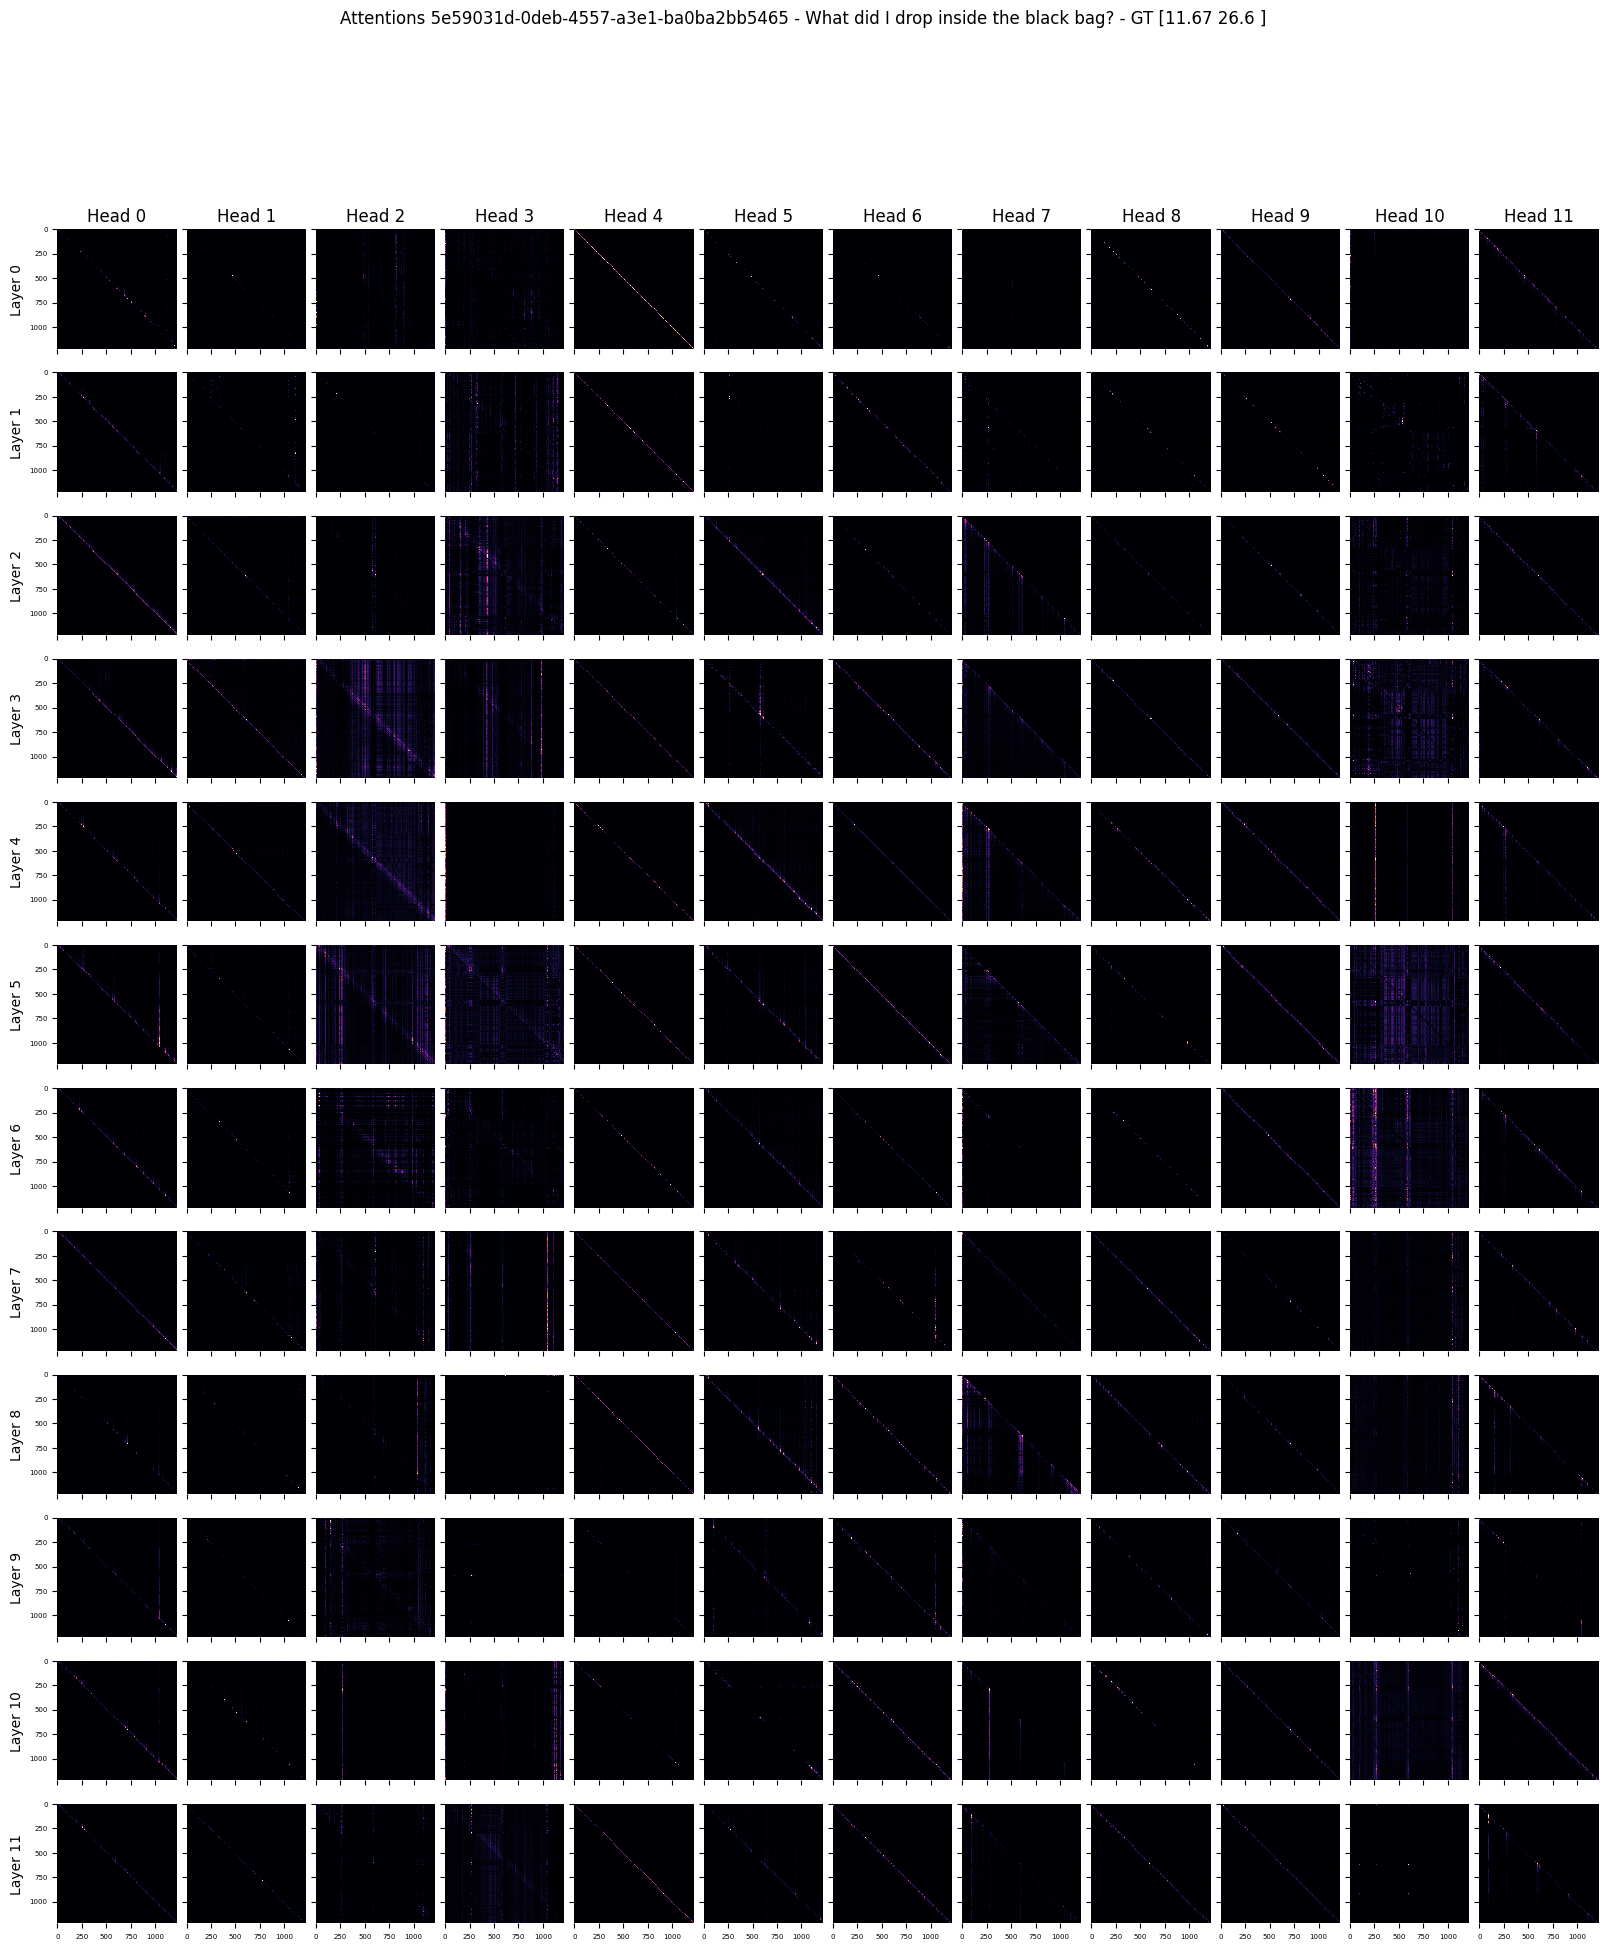

In [84]:
# 1 batch, 12 layers, 12 heads, 1215 tokens ** 2
# idx_layer, idx_head = 11, 0
# last_attention = encoder_outputs.attentions[idx_layer][0][idx_head]
num_layers = len(encoder_outputs.attentions)
num_heads = encoder_outputs.attentions[0].shape[1]
downsample = 10
fig, axes = plt.subplots(num_layers, num_heads, figsize=(20, 22), sharey=True, sharex=True, gridspec_kw={'wspace': 1e-2})
for idx_layer in range(num_layers):
    for idx_head in range(num_heads):
        ax = axes[idx_layer, idx_head]
        attention_map = encoder_outputs.attentions[idx_layer][0][idx_head][::downsample, ::downsample]  # [121, 121]
        sns.heatmap(attention_map.numpy(), cmap='magma', square=True, cbar=False, ax=ax)
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels, fontsize=5, rotation=0)
        ax.set_ylabel(f'Layer {idx_layer}')
        if idx_layer == num_layers-1:
            ticks = np.arange(0, attention_map.shape[0], 25)
            ticklabels = downsample * ticks
            ax.set_xticks(ticks)
            ax.set_xticklabels(ticklabels, fontsize=5, rotation=0)
        if idx_layer == 0:
            ax.set_title(f'Head {idx_head}')
fig.suptitle(f'Attentions {clip_uid} - {questions[batch_idx]} - GT {gt_segments[batch_idx].numpy().round(2)}')
plt.show()